In [5]:
import chardet
import pandas as pd
filename = "C:/Users/Admin/PycharmProjects/pythonProject4/preprocessed_result2_0614_burst.csv"
with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())  # or read() if the file is small.
    print(result['encoding'])

ascii


In [32]:
import treform as ptm

import pandas as pd
dict_list=[filename]
df= pd.read_csv('C:/Users/Admin/PycharmProjects/pythonProject4/preprocessed_result2_0613.csv', encoding='utf-8')

In [27]:
import pandas as pd

df = pd.read_csv('C:/Users/Admin/PycharmProjects/pythonProject4/result_add1.csv')
df.iloc[[2]]


,title,author,year,journal,abstract
2,위장관 ; 과민성 장 증후군 환자를 대상으로 Fenoverine과 Trimebuti...,"강성희 ( Seong Hee Kang ),진윤태 ( Yoon Tae Jeen ),구...",2013,대한소화기학회지,목적 진경제는 과민성 장 증후군의 치료제로 흔하게 사용하고 있다 그러나 과민성 장 ...


In [40]:
### aria1th@github
### saved as stopword_brief.py

import os
import pandas as pd
from tqdm import tqdm
from collections import Counter # for counting words

encoding = 'utf-8'
def read_stopwords(stop_word_file):
    with open(stop_word_file, 'r', encoding=encoding) as f:
        stop_words = f.read().splitlines()
    return set(stop_words)

# use Komoran to tokenize
from konlpy.tag import Komoran
komoran = Komoran()

def tokenize(text):
    # check if text is string
    if not isinstance(text, str) or text == "":
        return ""
    return " ".join(komoran.morphs(text))

# select nouns only
def tokenize_nouns(text):
    # check if text is string
    if not isinstance(text, str) or text == "":
        return ""
    return " ".join(komoran.nouns(text))

# pos tagger
def pos_tagger(text):
    # check if text is string
    if not isinstance(text, str) or text == "":
        return ""
    return komoran.pos(text)

# select by set
def select_by_set(text, iterable):
    tagged = pos_tagger(text)
    # print types of pos tag
    #print(set([tag for word, tag in tagged]))
    if tagged == "":
        return ""
    return " ".join([word for word, tag in tagged if tag in iterable])

def remove_stopwords(text, stop_word_file):
    stop_words = read_stopwords(stop_word_file)
    return " ".join([word for word in str(text).split() if word not in stop_words])

def count_words(text, counter):
    for word in str(text).split():
        counter[word] += 1
    return counter

def apply_threshold(counter, threshold = 10):
    # return set of words whose count is above threshold
    return set([word for word, count in counter.items() if count >= threshold])

def prune_by_threshold(text, word_set):
    return " ".join([word for word in str(text).split() if word in word_set])

def apply_remove_stopwords(df, column, stop_word_file, tokenize_option:str|set|list = "nouns"):
    if tokenize_option == "nouns":
        tokenize_func = tokenize_nouns
    elif tokenize_option == "morphs":
        tokenize_func = tokenize
    elif type(tokenize_option) in [set, list]:
        # if tokenize_option is set, use select_by_set
        tokenize_func = lambda x: select_by_set(x, tokenize_option)
    else:
        raise ValueError("tokenize_option should be 'nouns' or 'morphs'")
    # first tokenize, with tqdm to show progress
    for i in tqdm(range(len(df))):
        df.iloc[i, column] = tokenize_func(df.iloc[i, column])
    # for all rows in column 4, apply remove_stopwords
    df.iloc[:, column] = df.iloc[:, column].apply(lambda x: remove_stopwords(x, stop_word_file))
    return df

def apply_count_threshold(df, column, threshold = 10):
    counter = Counter()
    # count words in column 4
    for i in tqdm(range(len(df))):
        counter = count_words(df.iloc[i, column], counter)
    # apply threshold
    word_set = apply_threshold(counter, threshold)
    # prune by threshold
    df.iloc[:, column] = df.iloc[:, column].apply(lambda x: prune_by_threshold(x, word_set))
    return df


path = r'C:\Users\Scarlet\Documents\카카오톡 받은 파일\teamproject'
csv = 'result_add1.csv'
stopwords = 'stopwordsKor_riss.txt'

df = pd.read_csv(os.path.join(path, csv), encoding='utf-8')

# column is 'abstract' at 5th (index 4)
# test default
df = apply_remove_stopwords(df, 4, os.path.join(path, stopwords))

# apply count threshold
df = apply_count_threshold(df, 4, threshold = 10)

# test with set {'NNG', 'NNP'} where NNG is common noun, NNP is proper noun
#df = apply_remove_stopwords(df, 4, os.path.join(path, stopwords), tokenize_option={'NNG', 'NNP'})

# test verb only
#df = apply_remove_stopwords(df, 4, os.path.join(path, stopwords), tokenize_option={'VV'})
# save as csv
df.to_csv(os.path.join(path, 'result_add1_stopwords.csv'), encoding='utf-8', index=False)

100%|██████████| 3140/3140 [00:57<00:00, 54.73it/s] 


In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec= CountVectorizer(tokenizer=tokenizer,
                     max_df=0.5, min_df=5,
                     max_features=1000)

pet_cv = vec.fit_transform(df['abstract'].values.astype('U'))
print(pet_cv.shape)

C:\Users\Admin\PycharmProjects\pythonProject4\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3140, 1000)


In [42]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english',
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(df['abstract'].values.astype('U'))

In [43]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5,
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online',
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3140, 10)
#Sample of review_topics: [0.038 0.04  0.037 0.224 0.037 0.052 0.04  0.267 0.179 0.085]
#Sum of topic weights of documents: [0.108 0.089 0.093 0.088 0.103 0.122 0.098 0.097 0.116 0.087]
#shape of topic word distribution: (10, 1187)


In [64]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names_out(), 10)

CPU times: total: 1.23 s
Wall time: 11.8 s
Topic #0: 간호, 간호사, 관리, 활동, 인식, 영향, 자료, 요인, 수행, 교육
Topic #1: 방사선, 선량, 사용, 검사, 이용, 영상, 평가, 장치, 피폭, 촬영
Topic #2: 정보, 의료, 기술, 서비스, 정책, 시스템, 환경, 필요, 관리, 활용
Topic #3: 수술, 시행, 시술, 합병증, 발생, 검사, 절제, 내시경, 치료, 진단
Topic #4: 의료, 병원, 사고, 교육, 기관, 관리, 간호, 감염, 필요, 예방
Topic #5: 검사, 사용, 유의, 약물, 투여, 차이, 효과, 감소, 평가, 혈액
Topic #6: 치료, 운동, 효과, 신경, 진정, 관절, 장애, 사용, 기능, 마취
Topic #7: 재난, 평가, 집단, 효과, 프로그램, 신체, 기능, 도구, 유전자, 사용
Topic #8: 의료, 보험, 진료, 건강, 의약품, 제도, 필요, 급여, 아야, 의사
Topic #9: 치료, 효과, 요법, 투여, 시행, 방사선, 부작용, 기간, 반응, 재발


n_components: 3, perplexity: 420.929
n_components: 4, perplexity: 413.993
n_components: 5, perplexity: 411.750
n_components: 6, perplexity: 397.324
n_components: 7, perplexity: 400.499
n_components: 8, perplexity: 406.555
n_components: 9, perplexity: 403.077
n_components: 10, perplexity: 392.879


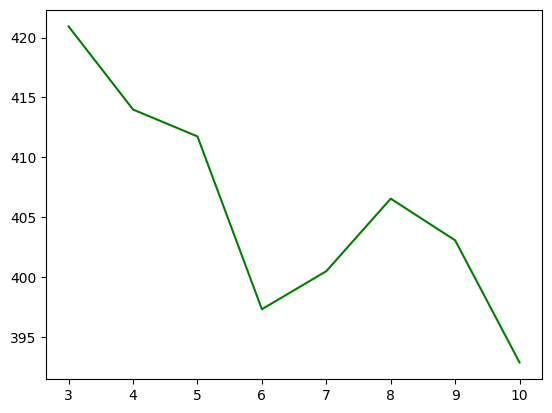

10

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1,
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter,
                                        topic_word_prior= topic_word_prior,
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=3, end=10)

In [63]:
#토픽  6개로 새로 실시

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 6, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names_out(), 10)

CPU times: total: 594 ms
Wall time: 2.35 s
Topic #0: 보험, 건강, 의료, 의약품, 진료, 급여, 증가, 제도, 보장, 국민
Topic #1: 치료, 사용, 방사선, 운동, 검사, 선량, 이용, 평가, 적용, 영상
Topic #2: 간호, 관리, 간호사, 교육, 활동, 인식, 영향, 자료, 수행, 요인
Topic #3: 수술, 시행, 치료, 시술, 합병증, 발생, 검사, 절제, 내시경, 관찰
Topic #4: 의료, 기관, 병원, 관리, 정보, 필요, 발생, 사고, 아야, 의사
Topic #5: 치료, 효과, 투여, 사용, 약물, 검사, 유의, 감소, 요법, 부작용


In [62]:
#토픽 6개
#
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(0, 6)])
trend_data = pd.concat([trend_data, df.year], axis=1)
trend_data.iloc[:6, -5:]

,Topic2,Topic3,Topic4,Topic5,year
0,0.002294,0.612744,0.002323,0.378028,2008
1,0.002236,0.769805,0.002235,0.002258,2007
2,0.001751,0.001749,0.001745,0.991257,2013
3,0.001535,0.001533,0.001535,0.877701,2002
4,0.791612,0.059093,0.145206,0.001369,2021
5,0.002305,0.002313,0.988483,0.002295,2017


In [58]:
#토픽6개

trend = trend_data.groupby(['year']).mean()
trend.iloc[:5, -5:]

,Topic1,Topic2,Topic3,Topic4,Topic5
year,,,,,
1958,0.075686,0.003799,0.591433,0.024154,0.301056
1962,0.929774,0.013991,0.014097,0.014033,0.014124
1968,0.542621,0.007595,0.169322,0.007641,0.265223
1974,0.003635,0.032727,0.282462,0.043454,0.634102
1976,0.002664,0.002665,0.986685,0.002663,0.002668


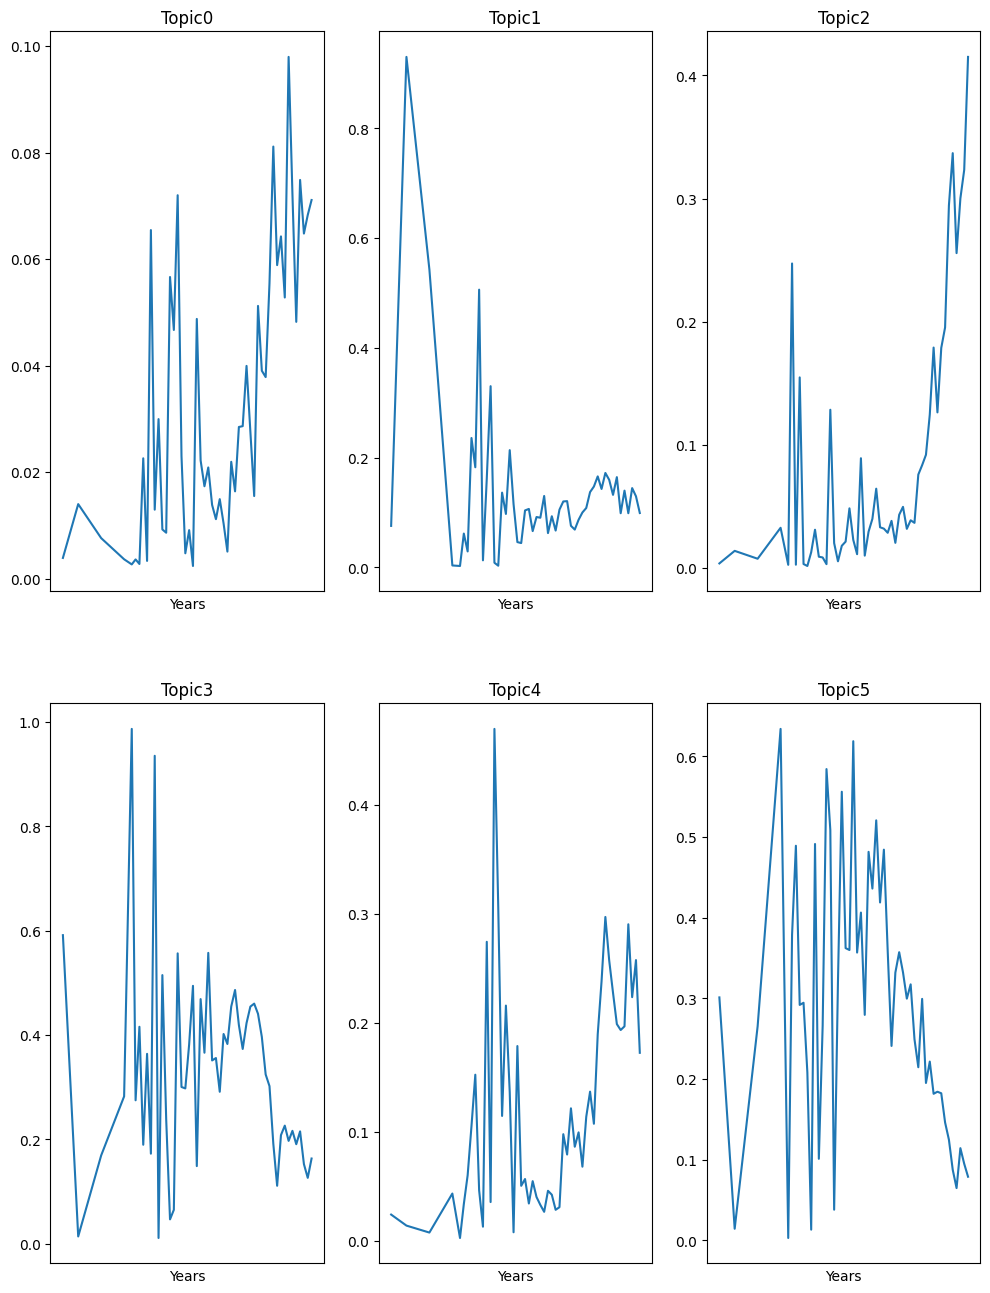

In [60]:
#토픽 6개

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
%matplotlib inline

fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12, 16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.plot(trend[col])
    ax.xaxis.set_major_locator(YearLocator(base=1958))
    ax.set_xlabel('Years')
plt.show()

In [26]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(0, 5)])
trend_data = pd.concat([trend_data, df.year], axis=1)
trend_data.iloc[:5, -5:]

,Topic1,Topic2,Topic3,Topic4,year
0,0.002261,0.505220,0.002284,0.487926,2008
1,0.002652,0.727418,0.128547,0.138722,2007
2,0.001712,0.001719,0.001712,0.993146,2013
3,0.001454,0.001451,0.001461,0.924477,2002
4,0.929908,0.066080,0.001347,0.001345,2021


In [27]:
trend = trend_data.groupby(['year']).mean()
trend.iloc[:5, -5:]

,Topic0,Topic1,Topic2,Topic3,Topic4
year,,,,,
1958,0.024982,0.004394,0.440248,0.036248,0.494127
1962,0.239739,0.009665,0.009709,0.009780,0.731107
1968,0.009910,0.009805,0.292531,0.480847,0.206907
1974,0.058225,0.003645,0.224169,0.003660,0.710301
1976,0.003402,0.003389,0.889071,0.003402,0.100735


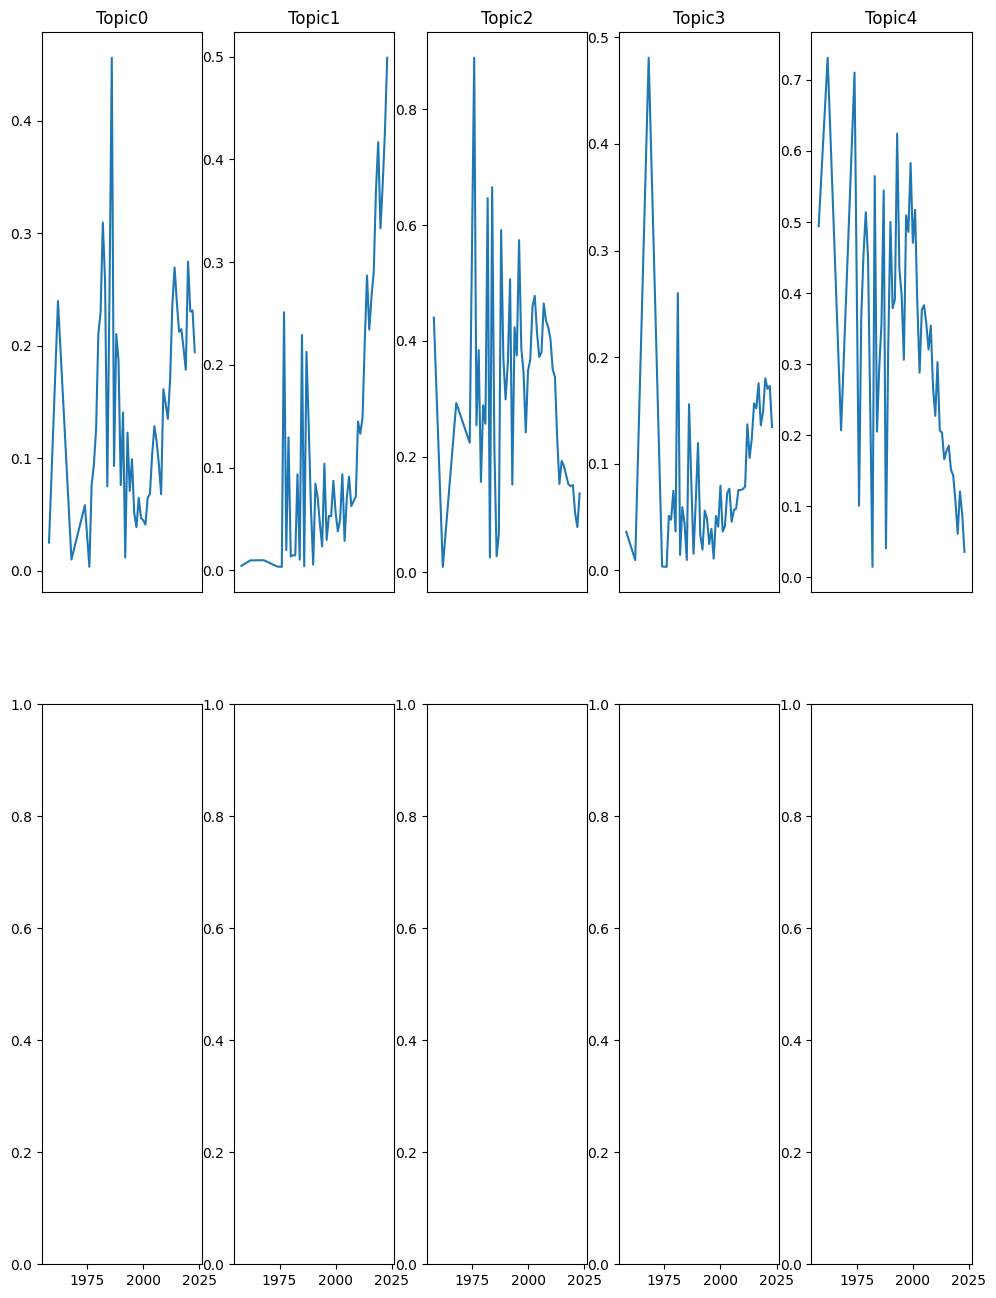

In [38]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 5, sharex='col', figsize=(12, 16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()